# Evaluation of distribution of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map, SUBREGIONS
from mlde_analysis.display import pretty_table, VAR_RANGES
from mlde_analysis.distribution import mean_bias, std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias, xr_hist, hist_dist, plot_distribution_figure, compute_metrics, DIST_THRESHOLDS
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop, threshold_exceeded_prop_error, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS, wd_mean, wd_mean_bias
from mlde_utils import cp_model_rotated_pole
from mlde_analysis import qq_plot, reasonable_quantiles

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
# Parameters
desc = "Comparison of diffusion model for CPMGEM-pr paper\nTest split\n12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set\nCompare techniques: diffusion, u-net, bilinear\n"
eval_vars = ["pr"]
derived_variables_config = {}
dataset_configs = {
    "CPM": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
    "GCM": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
}
split = "test"
ensemble_members = [
    "01",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "15",
]
samples_per_run = 6
sample_configs = {
    "CPM": [
        {
            "label": "CPMGEM_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "color": "tab:blue",
            "order": 11,
        },
        {
            "label": "U-Net_cCPM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/deterministic/ukcp_local_pr_12em_plain_unet/bham_pSTV-ema-gradcl-256-batch",
                    "checkpoint": "epoch_100",
                    "input_xfm": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-stan",
                    "dataset": "bham64_ccpm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:orange",
            "order": 1,
        },
        {
            "label": "cCPM Bilinear",
            "sample_specs": [
                {
                    "fq_model_id": "id-linpr",
                    "checkpoint": "epoch_0",
                    "input_xfm": "none",
                    "dataset": "bham64_ccpm-4x_12em_linpr_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": True,
            "color": "tab:grey",
            "order": 0,
            "UQ": False,
            "CCS": False,
        },
    ],
    "GCM": [
        {
            "label": "CPMGEM_GCM",
            "sample_specs": [
                {
                    "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV",
                    "checkpoint": "epoch_20",
                    "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                    "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                    "variables": ["pr"],
                }
            ],
            "deterministic": False,
            "CCS": True,
            "UQ": False,
            "color": "tab:green",
            "order": 20,
        }
    ],
}
sample_configs_at_60km = [
    {
        "label": "CPMGEM-GCM@60km",
        "sample_specs": [
            {
                "fq_model_id": "score-sde/subvpsde/ukcp_local_pr_12em_cncsnpp_continuous/bham-4x_12em_pSTV/postprocess/gcm-grid",
                "checkpoint": "epoch_20",
                "input_xfm": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr-pixelmmsstan",
                "dataset": "bham64_gcm-4x_12em_psl-sphum4th-temp4th-vort4th_pr",
                "variables": ["pr"],
            }
        ],
        "deterministic": False,
    }
]
dataset_configs_at_60km = {
    "CPM": "bham64_ccpm-60km_12em_pr_pr",
    "GCM": "bham64_gcm-60km_12em_rawpr_pr",
}
example_percentiles = {
    "CPM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
    "GCM": {
        "DJF Wet": {"percentile": 0.8, "variable": "pr", "season": "DJF"},
        "DJF Wettest": {"percentile": 1, "variable": "pr", "season": "DJF"},
        "JJA Wet": {"percentile": 0.8, "variable": "pr", "season": "JJA"},
        "JJA Wettest": {"percentile": 1, "variable": "pr", "season": "JJA"},
    },
}
example_overrides = {"CPM": {"JJA Wet": ["01", "1993-08-01 12:00:00"]}, "GCM": {}}
examples_sample_idxs = [2, 5]
niterations = 30


In [ ]:
IPython.display.Markdown(desc)

Comparison of diffusion model for CPMGEM-pr paper
Test split
12em dataset and models, 60km inputs -> 8.8km outputs, pSTV input variable set
Compare techniques: diffusion, u-net, bilinear


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 12, time: 3240,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 3, sample_id: 6, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01' '04' ... '13' '15'
   * time                        (time) object 1981-03-01 12:00:00 ... 2076-08...
     season                      (time) int64 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
   * model                       (model) object 'CPMGEM_cCPM' ... 'cCPM Bilinear'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1981 1981 1981 ... 2076 2076 2076
     stratum                     (time) <U12 'historic MAM' ... 'future JJA'
     tp_season_year             

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"].rename(f"cpm_{var}") for var in eval_vars }

VAR_DAS = {
    var: xr.merge([ EVAL_DS[source][f"pred_{var}"] for source, models in MODELS.items() for model, spec in models.items() ] + [CPM_DAS[var]])
for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() }

## Figure: distribution

* Frequency Density Histogram of rainfall intensities
* Maps of Mean bias ($\frac{\mu_{sample}-\mu_{CPM}}{\mu_{CPM}}$) over all samples, time and ensemble members
* Std Dev Bias $\frac{\sigma_{sample}}{\sigma_{CPM}}$ over all samples, time and ensemble members

### pr

[['Density' 'Density' 'Density' 'Density']
 ['meanb cCPM Bilinear' 'meanb U-Net_cCPM' 'meanb CPMGEM_cCPM'
  'meanb CPMGEM_GCM']
 ['stddevb cCPM Bilinear' 'stddevb U-Net_cCPM' 'stddevb CPMGEM_cCPM'
  'stddevb CPMGEM_GCM']]


6.2793370627572015e-09
5e-10


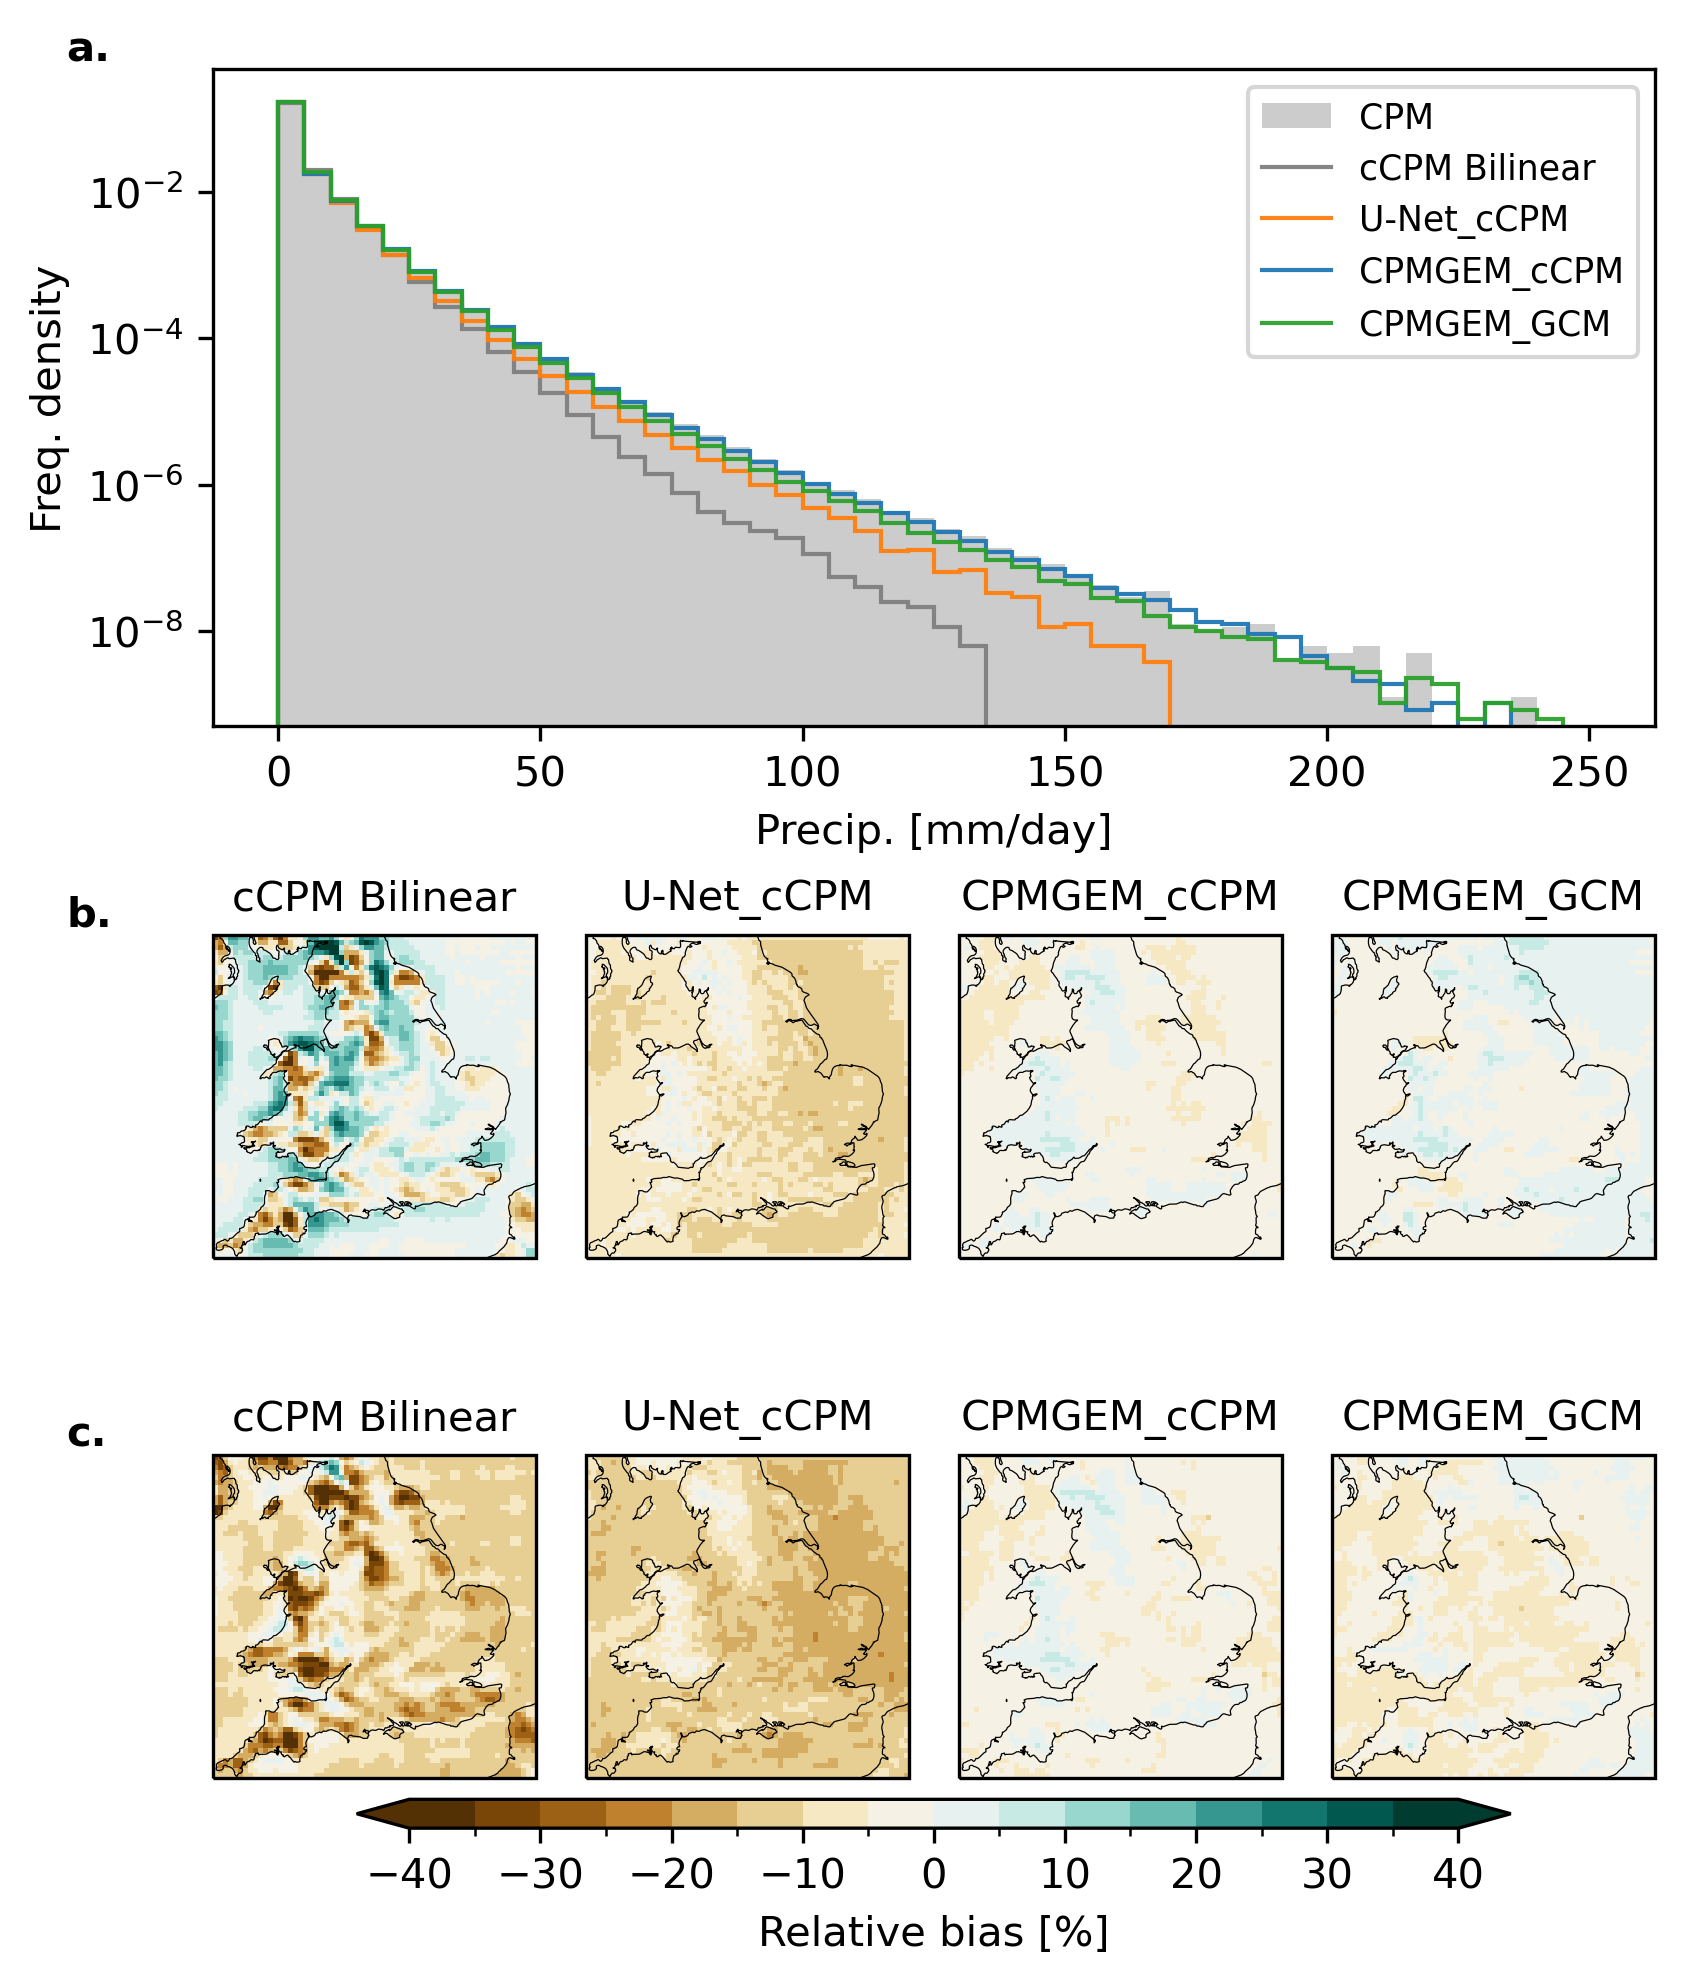

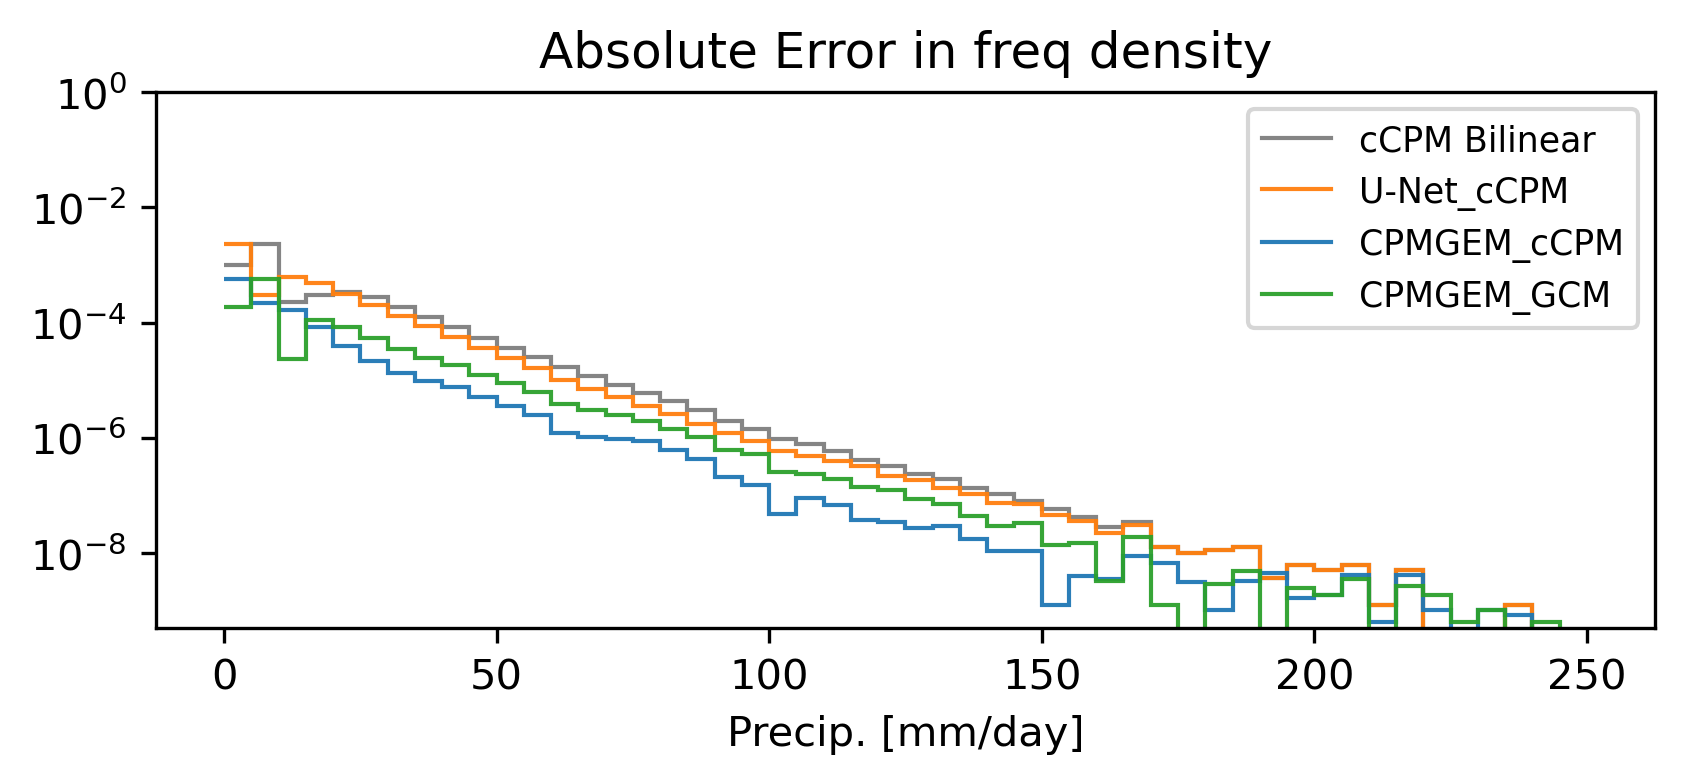

[['Density' 'Density' 'Density' 'Density']
 ['meanb cCPM Bilinear' 'meanb U-Net_cCPM' 'meanb CPMGEM_cCPM'
  'meanb CPMGEM_GCM']
 ['stddevb cCPM Bilinear' 'stddevb U-Net_cCPM' 'stddevb CPMGEM_cCPM'
  'stddevb CPMGEM_GCM']]


6.2793370627572015e-09
5e-10


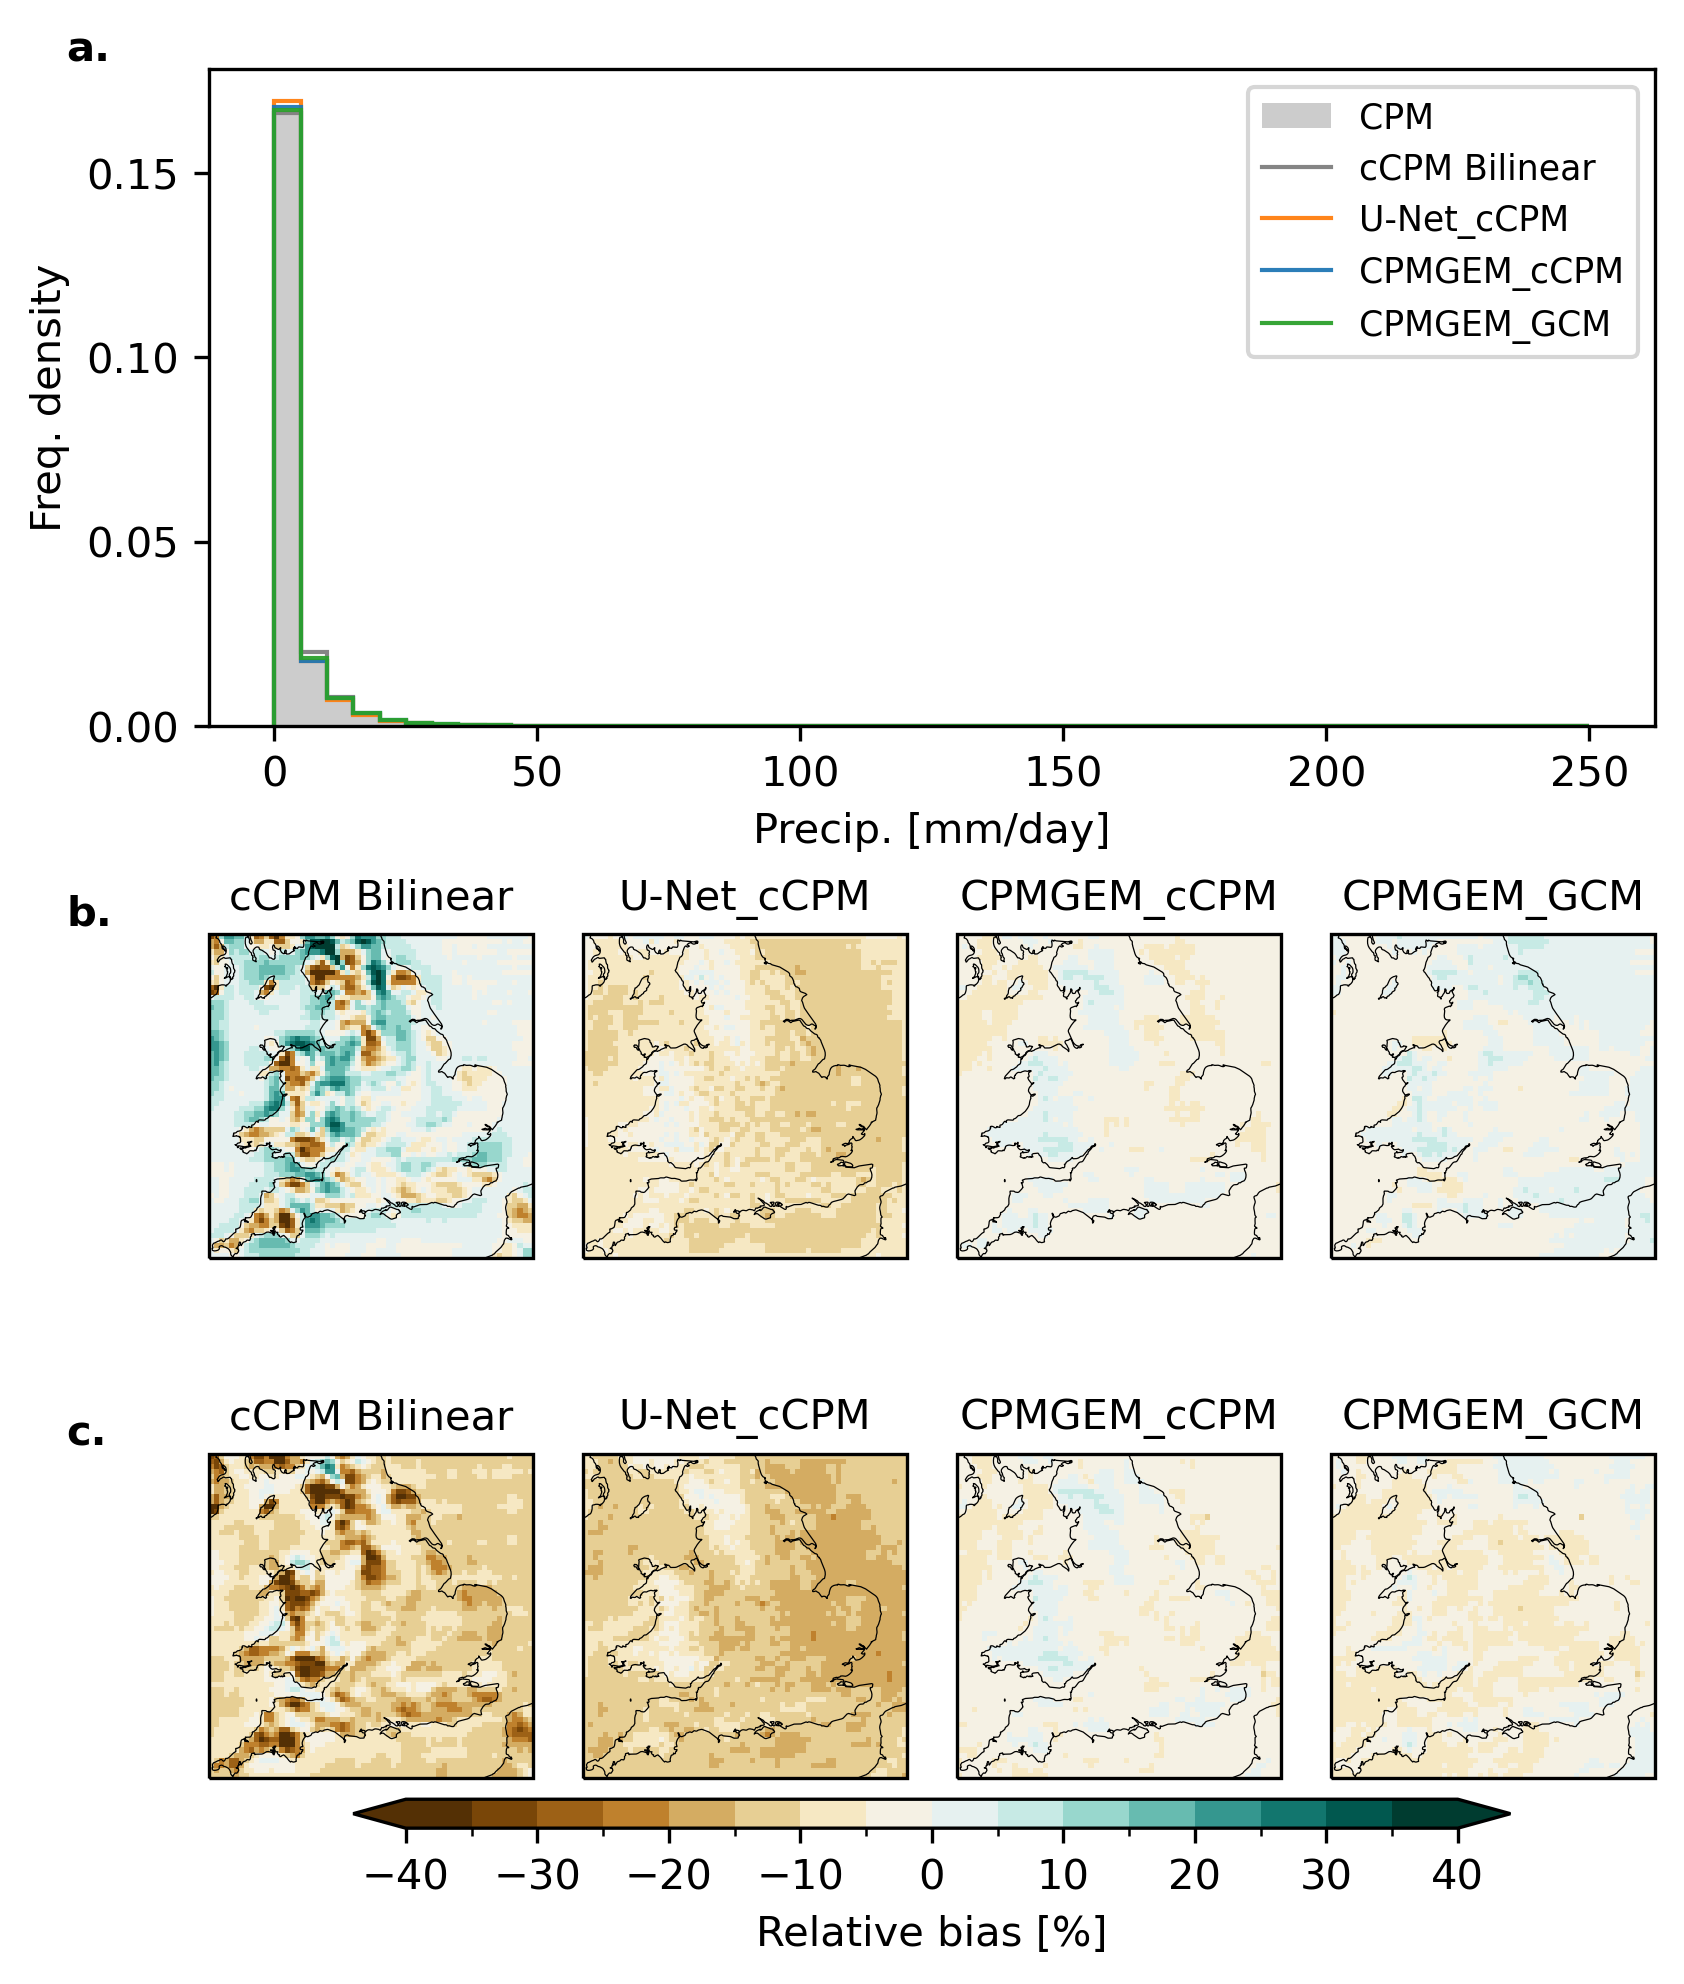

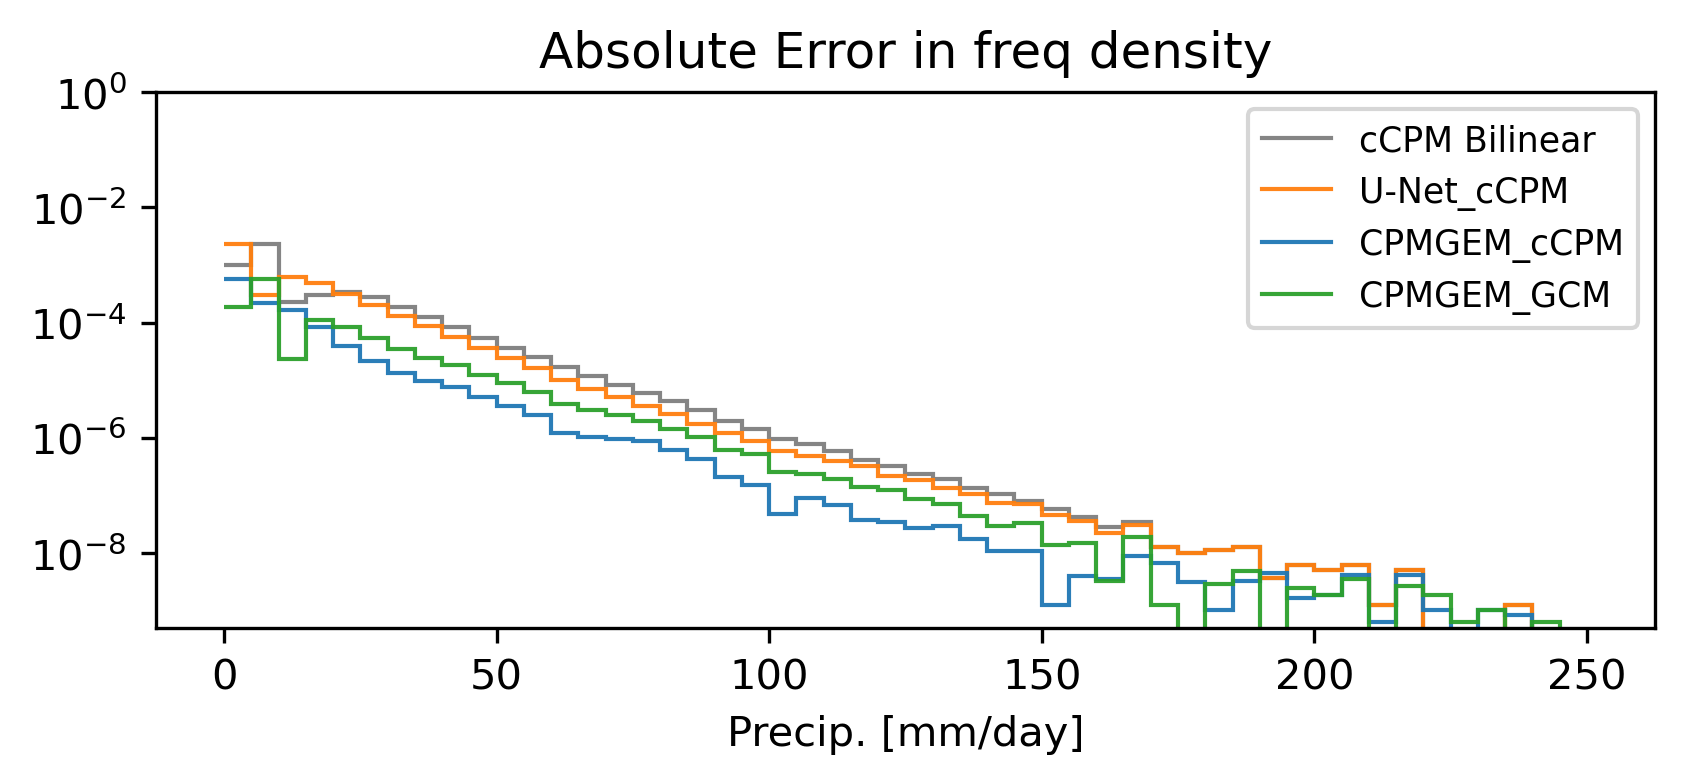

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    hist_das = VAR_DAS[var][f"pred_{var}"]
    cpm_da = CPM_DAS[var]
    normalize=(var == "pr")
    mean_biases = VAR_DAS[var][f"pred_{var}"].groupby("model").map(mean_bias, cpm_da=VAR_DAS[var][f"cpm_{var}"], normalize=(var=="pr"))

    std_biases = VAR_DAS[var][f"pred_{var}"].groupby("model").map(std_bias, cpm_da=VAR_DAS[var][f"cpm_{var}"], normalize=(var=="pr"))

    bias_kwargs = {"style": f"{var}Bias"}
    for fd_kwargs in [{"yscale": "log"}, {"yscale": "linear"}]:
        fig = plt.figure(layout="constrained", figsize=(5.5, 6.5))
        error_fig = plt.figure(layout="constrained", figsize=(5.5, 2.5))
        error_axd = error_fig.subplot_mosaic([["Error"]])
        error_ax = error_axd["Error"]
        axd = plot_distribution_figure(fig, hist_das, cpm_da, mean_biases, std_biases, MODELLABEL2SPEC, error_ax=error_ax, hrange=VAR_RANGES[var], fd_kwargs=fd_kwargs, bias_kwargs=bias_kwargs)
        if var == "relhum150cm":
            axd["Density"].axvline(x=100, color='k', linestyle='--', linewidth=1)
        
        plt.show()

## RMS biases and J-S Distances

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)
    da = xr.concat([ ds[f"pred_{var}"] for source, ds in EVAL_DS.items() ], dim="model")
    cpm_da = CPM_DAS[var]
    metrics_ds = compute_metrics(da, cpm_da, thresholds=DIST_THRESHOLDS[var])
        
    pretty_table(metrics_ds, round=4)

### pr

RMS Mean Bias (mm/day) 
 RMS Std Dev Bias (mm/day) 
 Relative RMS Mean Bias (%) 
 Relative RMS Std Dev Bias (%) 
 J-S distance 
 Emu > 0.1 
 Emu > 0.1 - CPM > 0.1 
 Emu > 25 
 Emu > 25 - CPM > 25 
 Emu > 75 
 Emu > 75 - CPM > 75 
 Emu > 125 
 Emu > 125 - CPM > 125 
 
 
 model 
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 CPMGEM_GCM 
 0.0800 
 0.2300 
 2.6500 
 4.5600 
 0.0042 
 0.5465 
 0.0165 
 0.0090 
 -0.0009 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 CPMGEM_cCPM 
 0.0900 
 0.1800 
 3.4000 
 3.5700 
 0.0028 
 0.5257 
 -0.0044 
 0.0095 
 -0.0003 
 0.0001 
 -0.0000 
 0.0000 
 -0.0000 
 
 
 U-Net_cCPM 
 0.2100 
 0.6300 
 9.2800 
 13.2600 
 0.0168 
 0.5653 
 0.0353 
 0.0069 
 -0.0030 
 0.0001 
 -0.0001 
 0.0000 
 -0.0000 
 
 
 cCPM Bilinear 
 0.3700 
 0.9200 
 10.4100 
 13.8100 
 0.0213 
 0.6419 
 0.1118 
 0.0056 
 -0.0043 
 0.0000 
 -0.0001 
 0.0000 
 -0.0000

## QQ plots

### pr

-8


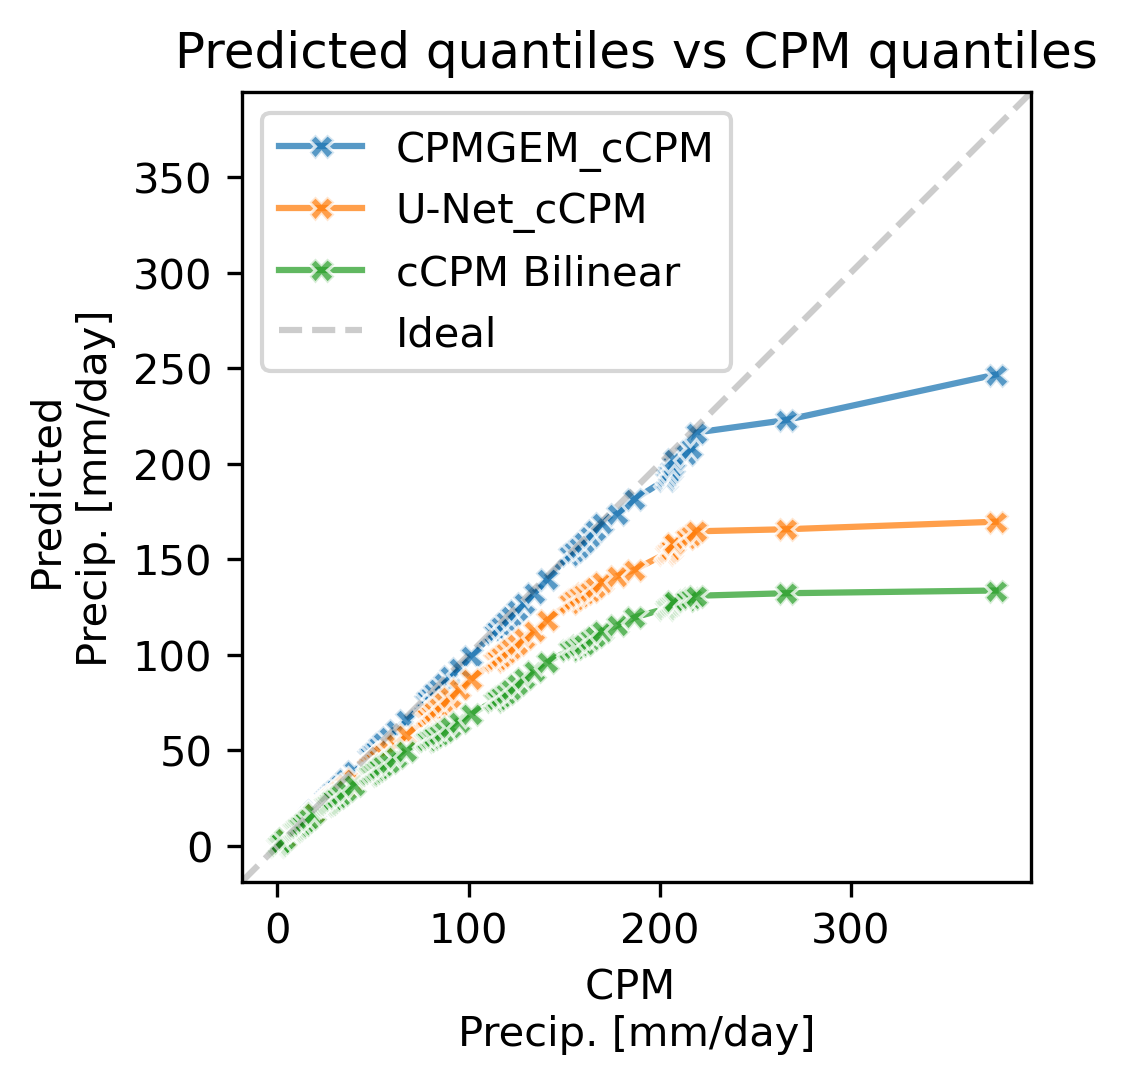

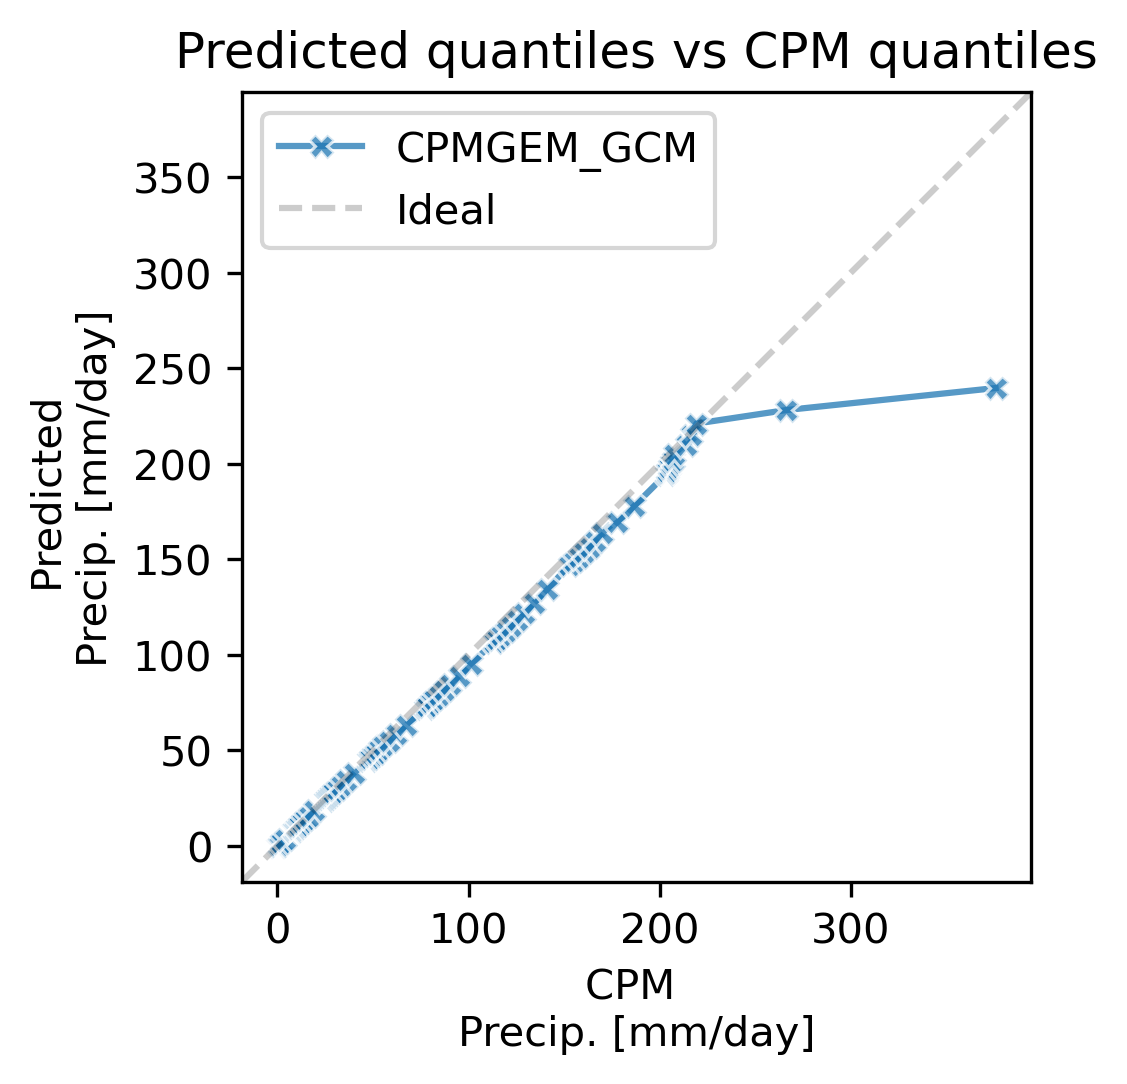

In [ ]:
quantile_dims=["ensemble_member", "time", "grid_latitude", "grid_longitude"]

for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    quantiles = reasonable_quantiles(CPM_DAS[var])
    cpm_quantiles = CPM_DAS[var].quantile(quantiles, dim=quantile_dims).rename("target_q")

    for source, ds in EVAL_DS.items():
        pred_da = ds[f"pred_{var}"]
        pred_quantiles = pred_da.quantile(quantiles, dim=quantile_dims).rename("pred_q")

        layout="constrained"

        fig, ax = plt.subplots(figsize=(3.5, 3.5), layout="constrained")

        xlabel = f"CPM \n{xr.plot.utils.label_from_attrs(da=CPM_DAS[var])}"
        ylabel = f"Predicted \n{xr.plot.utils.label_from_attrs(da=pred_da)}"

        qq_plot(ax, cpm_quantiles, pred_quantiles, title=f"Predicted quantiles vs CPM quantiles", xlabel=xlabel, ylabel=ylabel)

    plt.show()

## Figure: subdomain

### pr

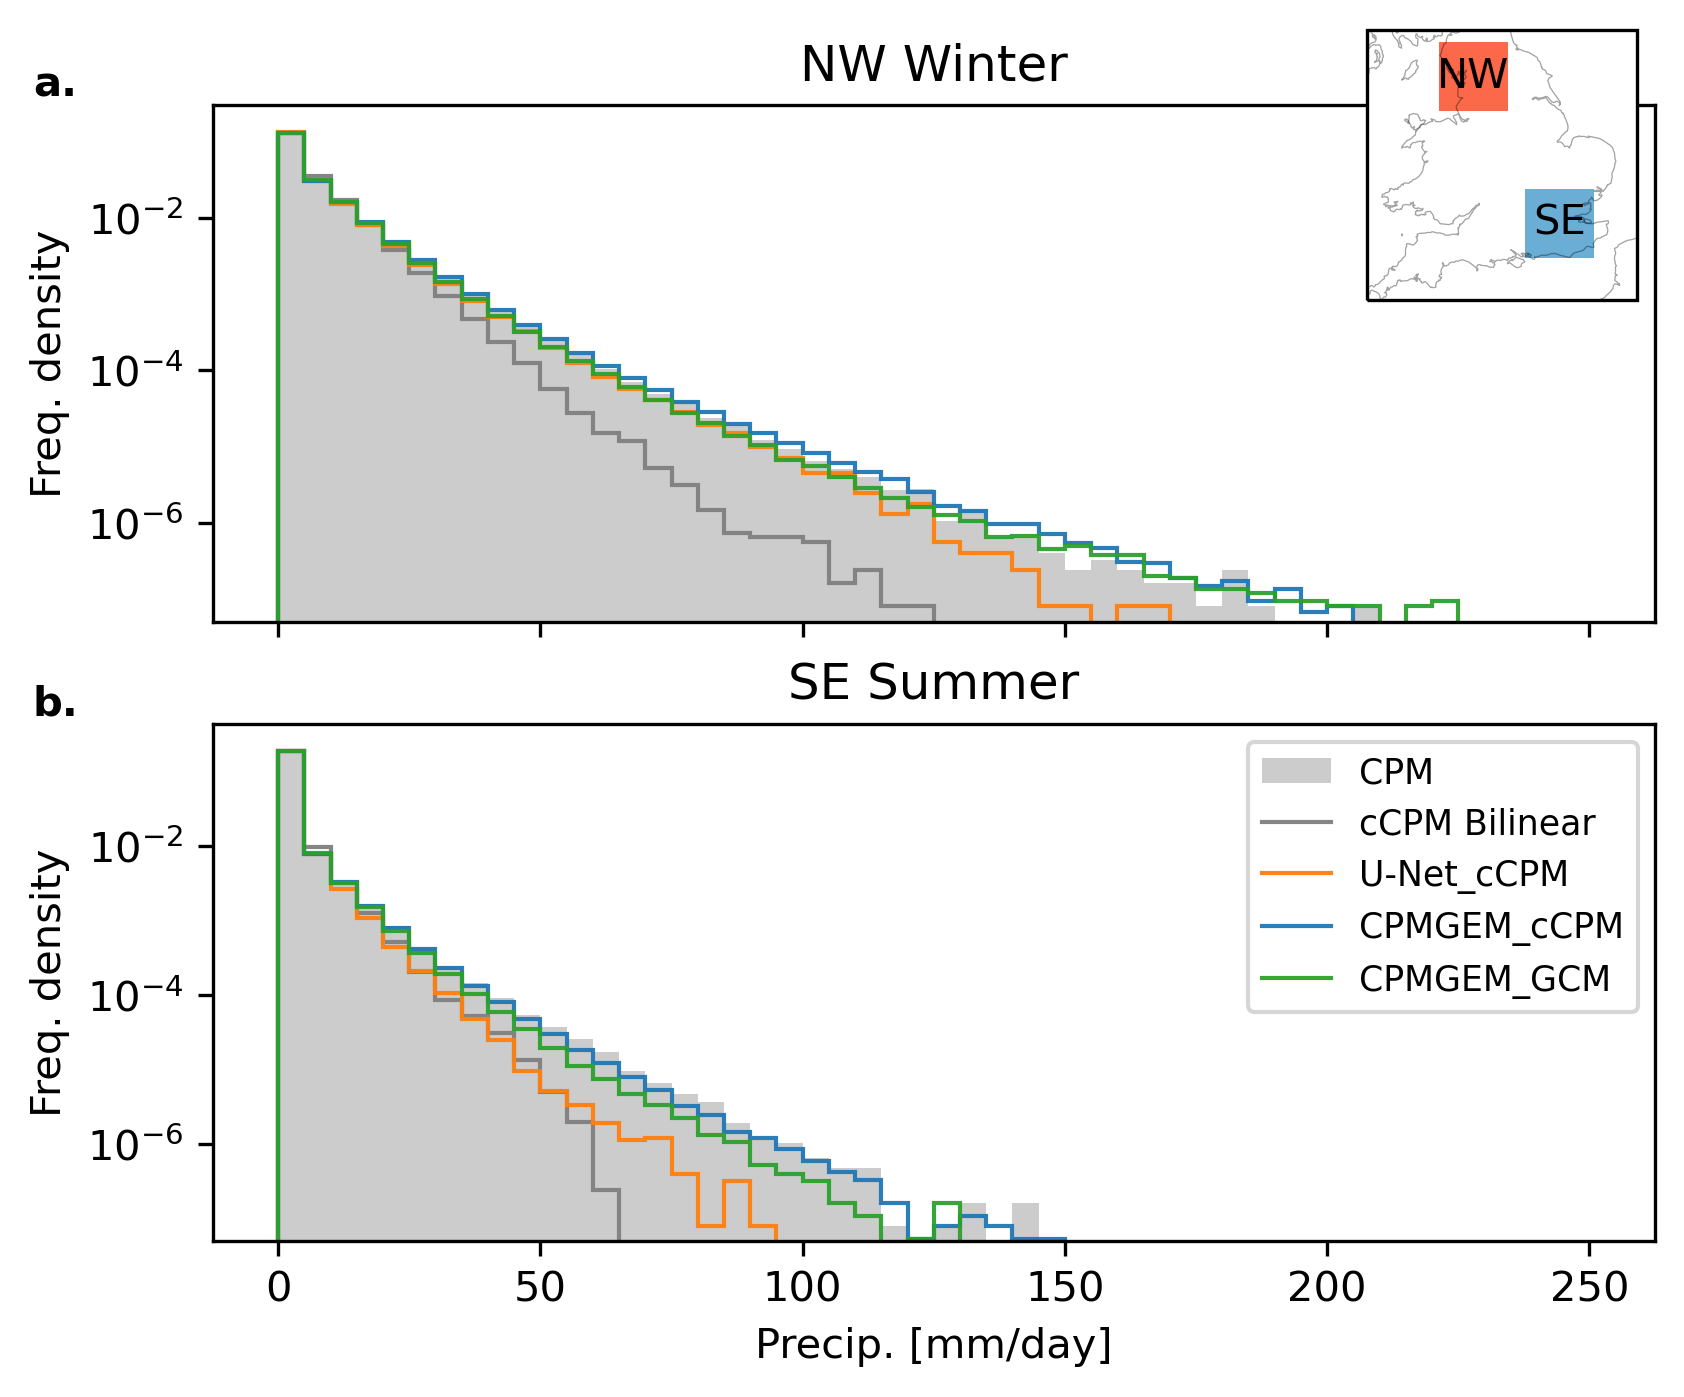

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)

    fd_fig = plt.figure(figsize=(5.5, 4.5), layout="constrained")

    human_names = {
        "DJF": "Winter",
        "JJA": "Summer",
    }

    axd = fd_fig.subplot_mosaic([["NW"], ["SE"]], sharex=True)
    
    for i, (srname, season) in enumerate([("NW", "DJF"), ("SE", "JJA")]):

        season_mask = CPM_DAS[var]["time"]["time.season"] == season

        srseason_cpm_da = CPM_DAS[var].isel(**SUBREGIONS[srname]).sel(time=season_mask)

        srseason_hist_data = [
            dict(data=EVAL_DS[source][f"pred_{var}"].sel(model=model).isel(**SUBREGIONS[srname]).sel(time=season_mask), label=model, color=spec["color"]) for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
        ]

        ax = axd[srname]
        if var == "pr":
            kwargs = {
                "yscale": "log",
            }
        else:
            kwargs = {
                "yscale": "linear",
            }
        plot_freq_density(srseason_hist_data, ax=ax, target_da=srseason_cpm_da, linewidth=1, hrange=VAR_RANGES[var], **kwargs)
        ax.set_title(f"{srname} {human_names[season]}")

        if i == 0:
            ax.set_xlabel("")
            ax.get_legend().remove()
            reg_ax = fd_fig.add_axes([0.8, 0.8, 0.2, 0.2], projection=cp_model_rotated_pole)
            # reg_ax = fd_fig.subplots(1, subplot_kw = dict(projection=cp_model_rotated_pole))
            nw_cpm_da = CPM_DAS[var].isel(**SUBREGIONS["NW"])
            se_cpm_da = CPM_DAS[var].isel(**SUBREGIONS["SE"])
            plot_map(10*xr.ones_like(nw_cpm_da.isel(ensemble_member=0, time=0)), ax=reg_ax, style=None, cmap="Reds", cl_kwargs=dict(alpha=0.2))
            plot_map(1*xr.ones_like(se_cpm_da.isel(ensemble_member=0, time=0)), ax=reg_ax, style=None, cmap="Blues", cl_kwargs=dict(alpha=0.2))
            reg_ax.annotate("NW", xy=(nw_cpm_da.grid_longitude.mean().values.item(), nw_cpm_da.grid_latitude.mean().values.item()), xycoords="data", fontsize="medium", ha="center", va="center")
            reg_ax.annotate("SE", xy=(se_cpm_da.grid_longitude.mean().values.item(), se_cpm_da.grid_latitude.mean().values.item()), xycoords="data", fontsize="medium", ha="center", va="center")
            reg_ax.set_extent([-2, 3, -2.5, 2.5], crs=cp_model_rotated_pole)


        ax.annotate(f"{string.ascii_lowercase[i]}.", xy=(0.02, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

    plt.show()

## Figure: Threshold exceedence

Threshold: 0.1mm/day 
 
 
   
   
 % Threshold exceeded 
 
 
 season 
 model 
   
 
 
 
 
 Annual 
 CPMGEM_GCM 
 54.7 
 
 
 CPMGEM_cCPM 
 52.6 
 
 
 U-Net_cCPM 
 56.5 
 
 
 cCPM Bilinear 
 64.2 
 
 
 CPM 
 53.0 
 
 
 DJF 
 CPMGEM_GCM 
 68.1 
 
 
 CPMGEM_cCPM 
 66.4 
 
 
 U-Net_cCPM 
 68.6 
 
 
 cCPM Bilinear 
 77.0 
 
 
 CPM 
 67.4 
 
 
 MAM 
 CPMGEM_GCM 
 58.9 
 
 
 CPMGEM_cCPM 
 56.2 
 
 
 U-Net_cCPM 
 58.4 
 
 
 cCPM Bilinear 
 66.4 
 
 
 CPM 
 55.7 
 
 
 JJA 
 CPMGEM_GCM 
 38.4 
 
 
 CPMGEM_cCPM 
 36.9 
 
 
 U-Net_cCPM 
 45.5 
 
 
 cCPM Bilinear 
 49.9 
 
 
 CPM 
 36.9 
 
 
 SON 
 CPMGEM_GCM 
 53.2 
 
 
 CPMGEM_cCPM 
 50.8 
 
 
 U-Net_cCPM 
 53.6 
 
 
 cCPM Bilinear 
 63.5 
 
 
 CPM 
 52.0

#### Threshold: 0.1mm/day

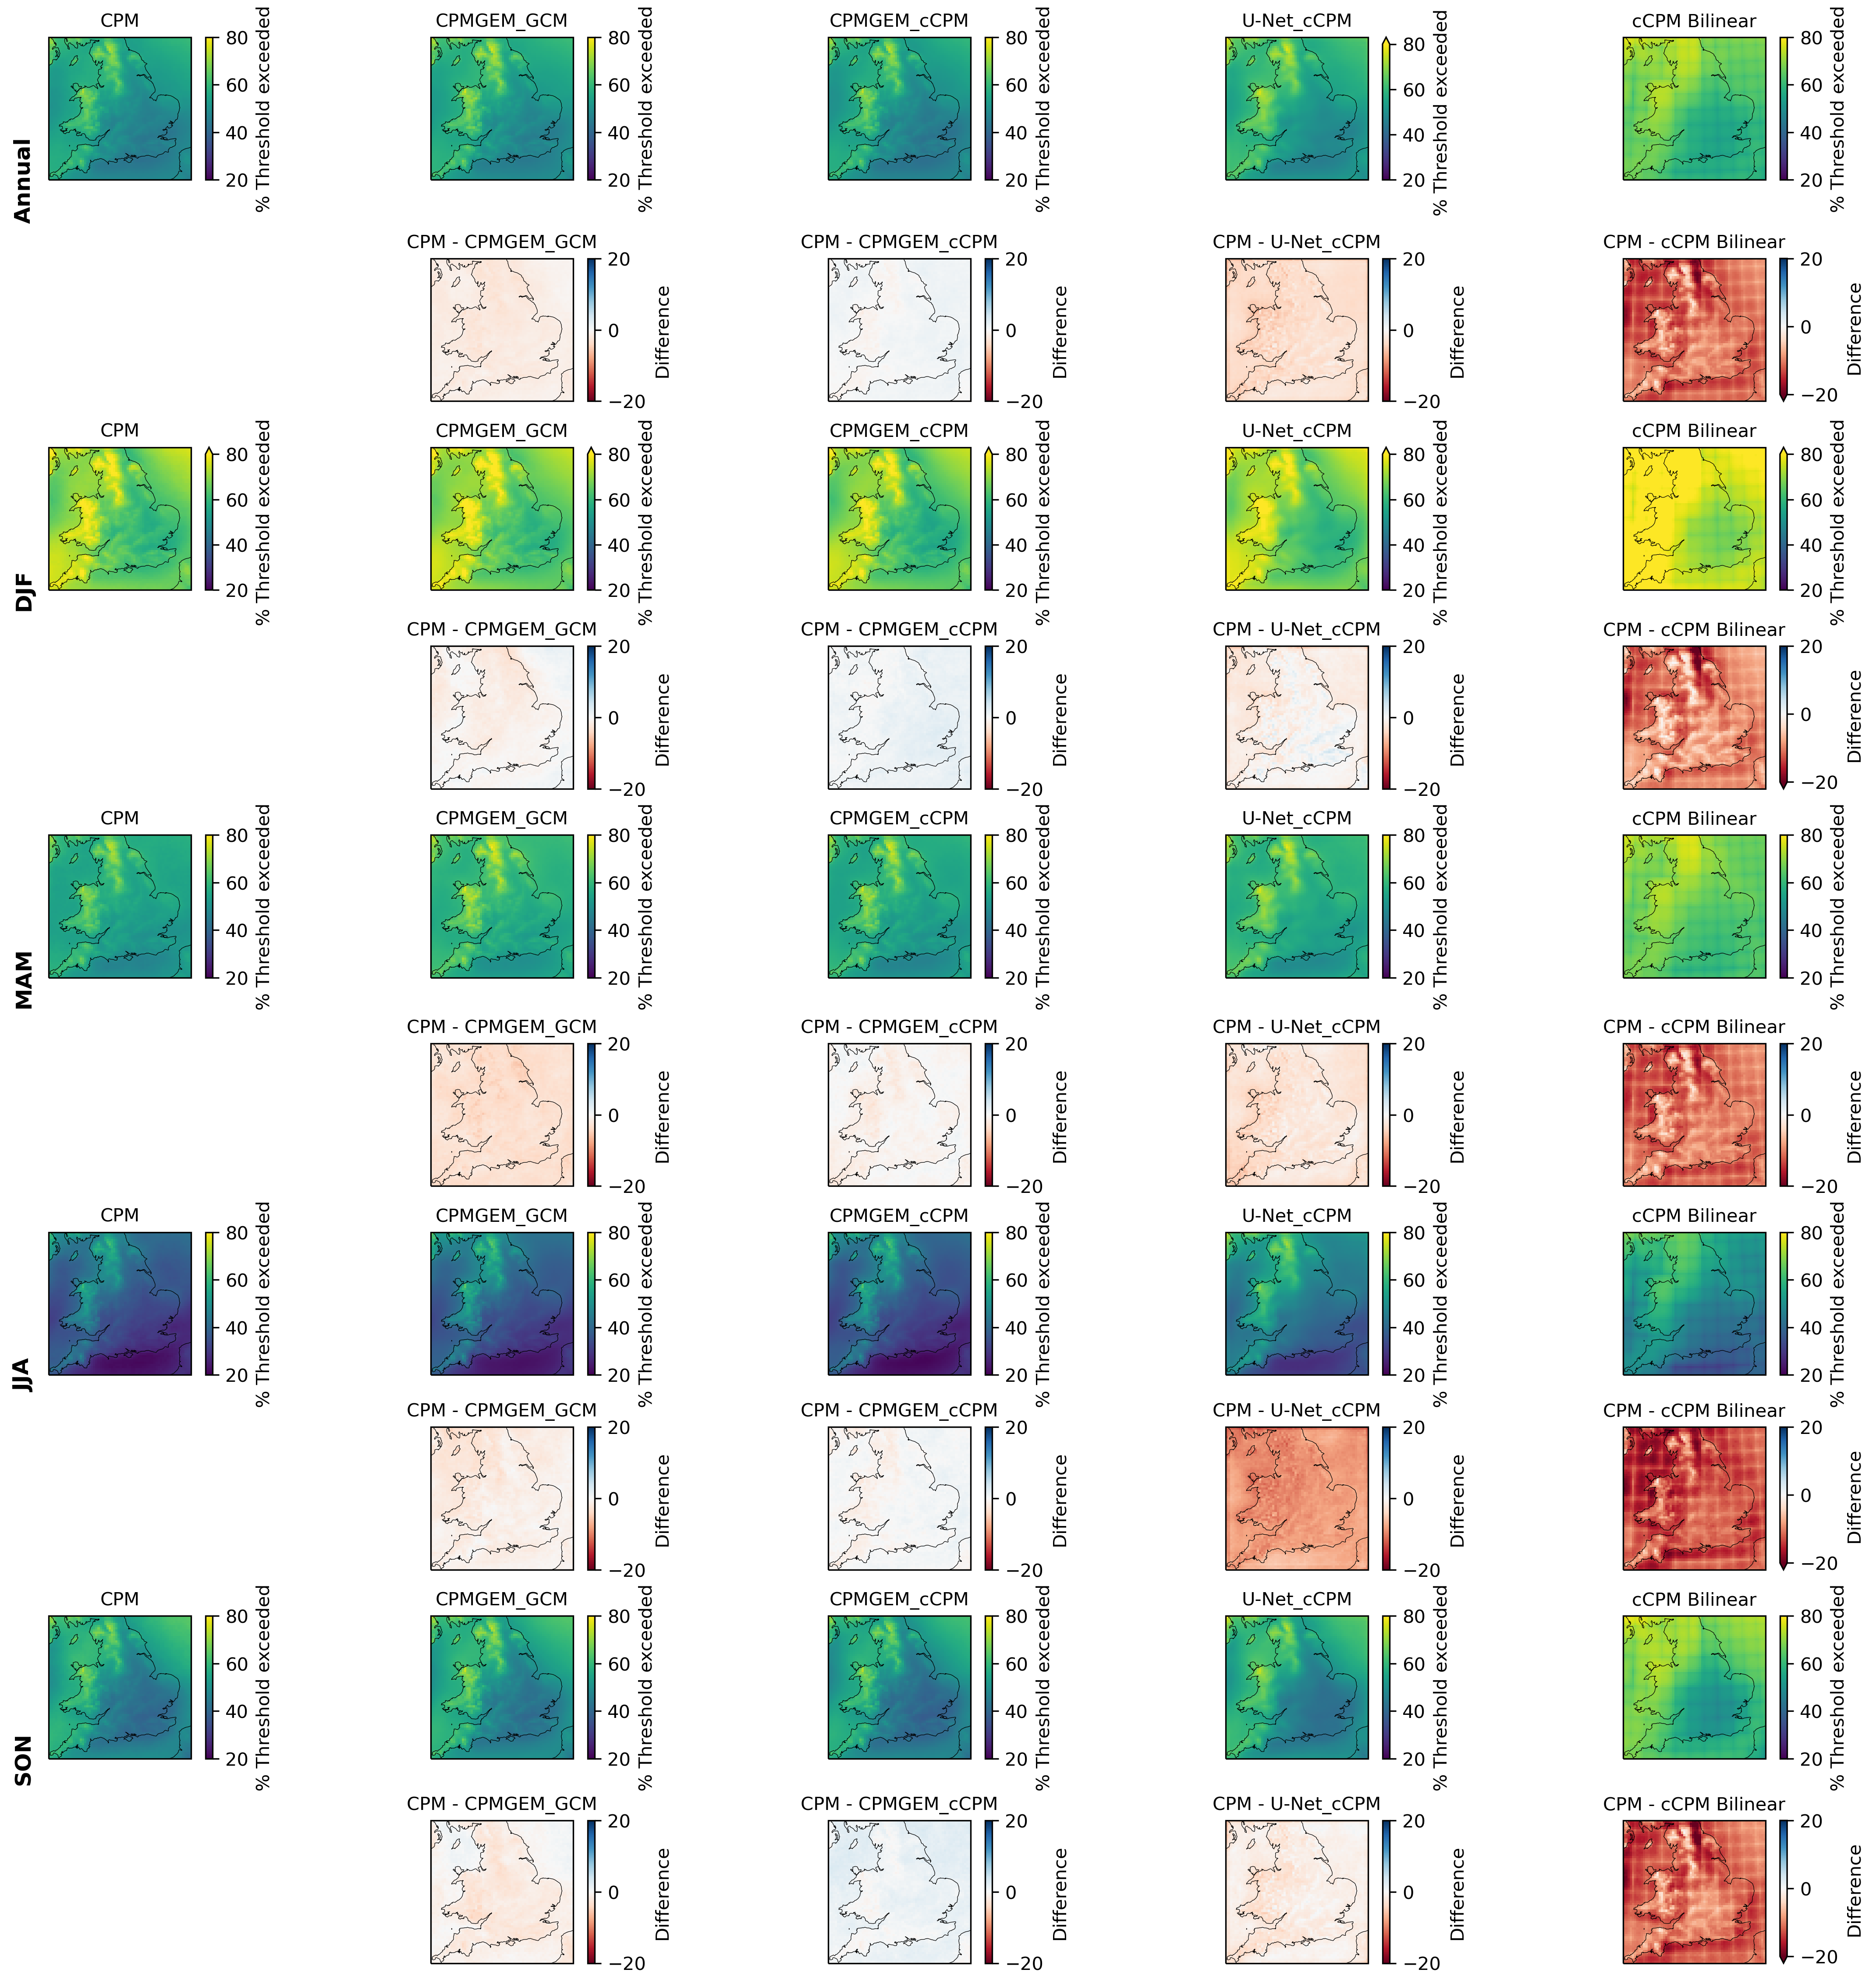

In [ ]:
for var, thresholds in THRESHOLDS.items():
    if var in eval_vars:
        model_das = [
            EVAL_DS[source][f"pred_{var}"].sel(model=model)
            for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
        ]

        threshold_exceeded_stats = { threshold: threshold_exceeded_prop_stats(VAR_DAS[var][f"pred_{var}"], CPM_DAS[var], threshold) for threshold in thresholds }

        dfs = [threshold_exceeded_stats[threshold].mean(dim=["grid_latitude", "grid_longitude"]).to_dataframe().style.set_table_attributes("style='display:inline'").set_caption(f"Threshold: {threshold}{CPM_DAS[var].attrs['units']}").format(precision=1).to_html() for threshold in thresholds]

        IPython.display.display_html(functools.reduce(lambda v, e: v+e, dfs), raw=True)

        for threshold in thresholds:
            IPython.display.display_markdown(f"#### Threshold: {threshold}{CPM_DAS[var].attrs['units']}", raw=True)

            plot_threshold_exceedence_errors(threshold_exceeded_stats[threshold])

            plt.show()

## Rough: wet-day mean

#### Threshold: 0.1mm/day

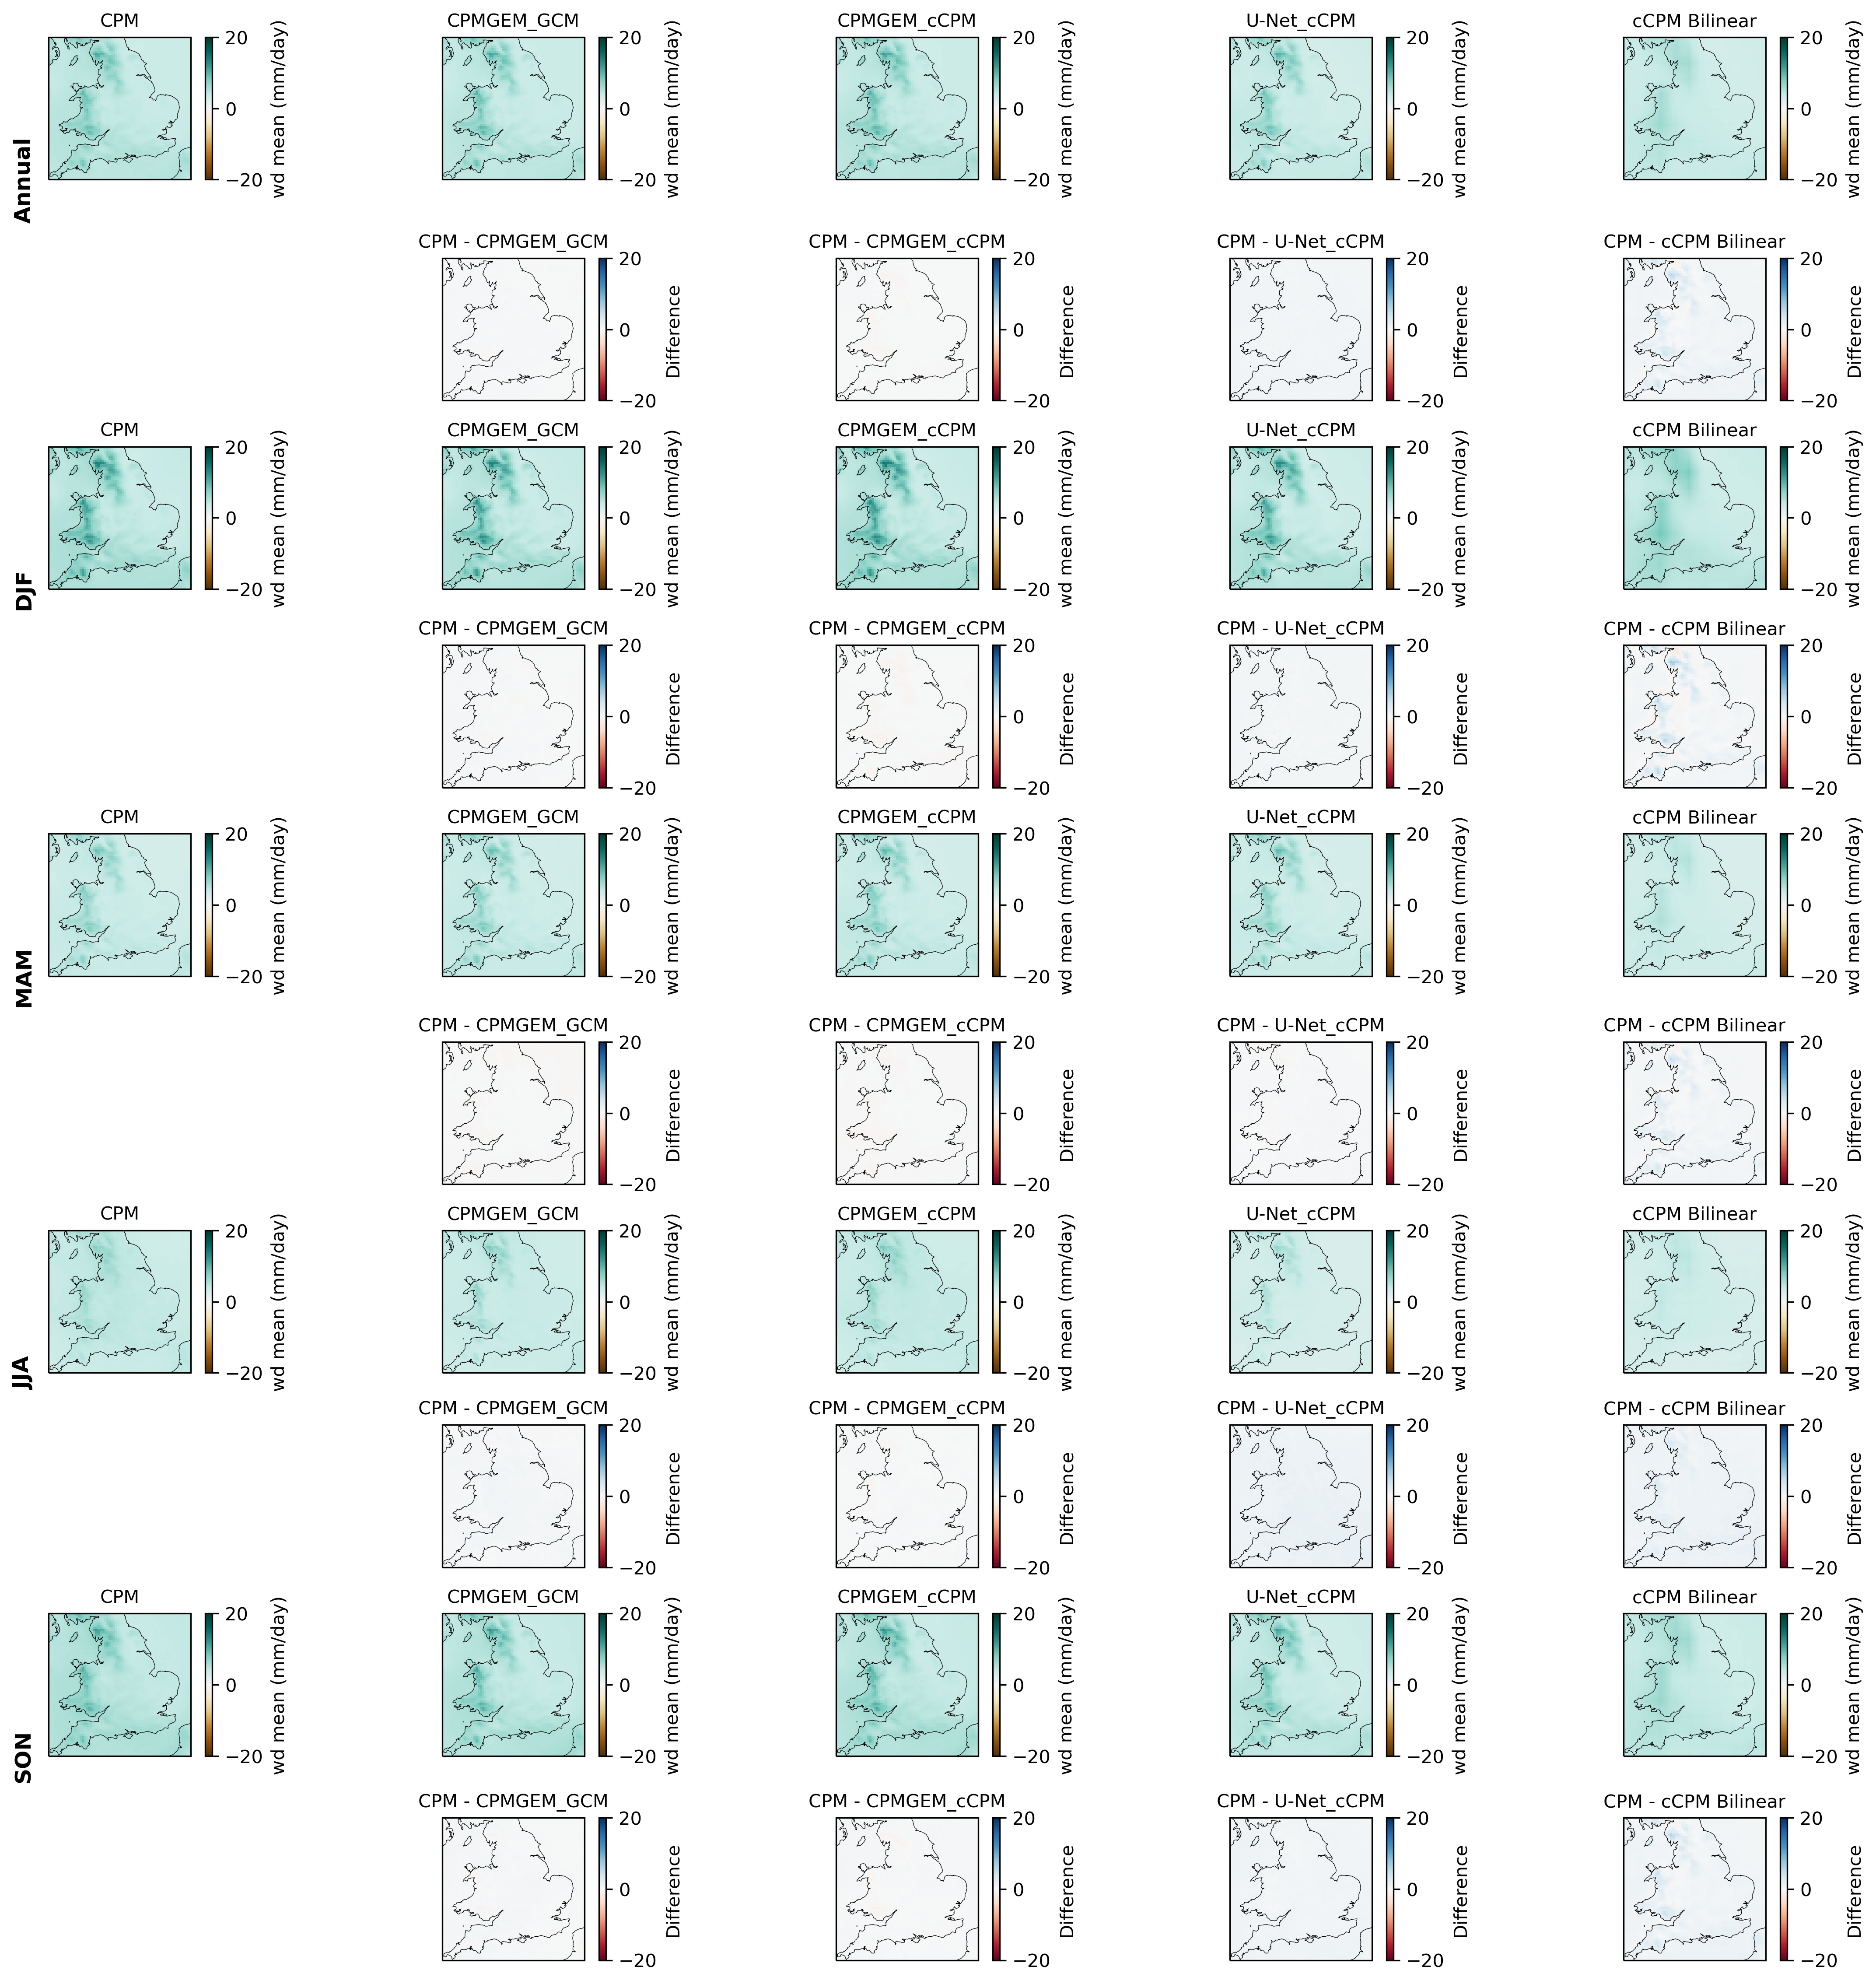

In [ ]:
model_das = [
    EVAL_DS[source]["pred_pr"].sel(model=model)
    for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
]

change_stats = { var: { threshold: threshold_exceeded_prop_stats(VAR_DAS[var][f"pred_{var}"], CPM_DAS[var], threshold=threshold, threshold_exceeded_prop_statistic=wd_mean) for threshold in thresholds } for var, thresholds in THRESHOLDS.items() if var in eval_vars }

for var, thresholds in THRESHOLDS.items():
    if var in eval_vars:
        for threshold in thresholds:
            IPython.display.display_markdown(f"#### Threshold: {threshold}mm/day", raw=True)
            
            plot_threshold_exceedence_errors(change_stats[var][threshold], style="change")
        
            plt.show()